# Seatle Airbnb Dataset

### In this notebook we will use the Seattle Airbnb dataset to answer the following questions:

1. What is the average nightly rate for different types of Airbnb listings in Seattle, and how does this vary by neighborhood?

2. Are there certain amenities that are associated with higher-rated Airbnb listings in Seattle, and if so, what are they?

3. Are there any trends or patterns in the types of guests who tend to book Seattle Airbnb listings (e.g. age, gender, nationality), and how might this data be useful for hosts?

4. What are the busiest times of the year to visit Seattle? By how much do prices spike?

5. How well can we predict the price of a listing, given its size (e.g. number of bedrooms, bathrooms, etc.) ?

In [24]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import re
%matplotlib inline

In [2]:
#read in the dataset
data = pd.read_csv('./archive/listings.csv')
print(data.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

## Question 1
#### What is the average nightly rate for different types of Airbnb listings in Seattle, and how does this vary by neighbourhood?

#### First, we need to know the number of missing values

In [3]:
def missing_values(df,col):
    total_count = np.sum(df[f'{col}'].isna())
    return (total_count , total_count / len(df[f'{col}']))

In [4]:
def remove_missing_rows(df,cols):
    '''
    Remove Rows that have NA in the given list of columns and having only those columns
    '''
    df = df.loc[:,cols]
    return df.dropna(subset = cols, how='any')

In [5]:
print(f"Number of missing values in, Property type : {missing_values(data,'property_type')[0]}"
        f", Price : {missing_values(data,'price')[0]}, Neighbourhood : {missing_values(data,'neighbourhood')[0]}")

Number of missing values in, Property type : 1, Price : 0, Neighbourhood : 416


As we can see the number of missing values are relatively low. In addition to that, the neighbourhood is fundamental in our analysis, so having missing values in the neghbourhood is irrelevant

In [6]:
q1_df = remove_missing_rows(data,['price','neighbourhood','property_type'])
q1_df.head()

,price,neighbourhood,property_type
0,$85.00,Queen Anne,Apartment
1,$150.00,Queen Anne,Apartment
2,$975.00,Queen Anne,House
3,$100.00,Queen Anne,Apartment
4,$450.00,Queen Anne,House


In [7]:
# change the price from string to int
q1_df['price'] = pd.to_numeric(q1_df['price'].str[1:],errors='coerce').dropna()
q1_df.head()

,price,neighbourhood,property_type
0,85.0,Queen Anne,Apartment
1,150.0,Queen Anne,Apartment
2,975.0,Queen Anne,House
3,100.0,Queen Anne,Apartment
4,450.0,Queen Anne,House


In [8]:
# get the avg of each property type across Seattle
q1_df1 = q1_df.groupby(['property_type'])['price'].aggregate(['min','mean','max']).sort_values(by='mean',ascending=False)
q1_df1.head()

,min,mean,max
property_type,,,
Boat,75.0,221.666667,775.0
Condominium,50.0,155.698795,700.0
Loft,49.0,135.970588,425.0
Townhouse,33.0,134.254717,498.0
House,25.0,132.673312,975.0


In [9]:
q1_df = q1_df.groupby(['property_type', 'neighbourhood'])['price'].aggregate(['min','mean','max']).sort_values(by='mean',ascending=False)
q1_df.head()

min        mean    max
property_type neighbourhood                                
Boat          Westlake             150.0  462.500000  775.0
House         Fairmount Park       370.0  370.000000  370.0
              Portage Bay           90.0  340.285714  750.0
Townhouse     Green Lake           325.0  325.000000  325.0
Loft          Industrial District  320.0  320.000000  320.0

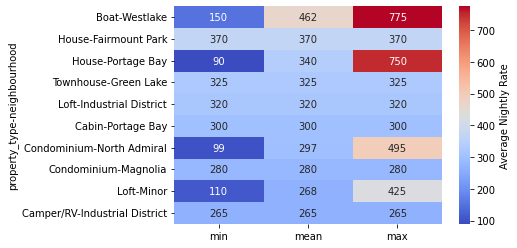

In [10]:
sns.heatmap(q1_df[:10],cmap='coolwarm', annot=True, fmt='.0f',cbar_kws={'label': 'Average Nightly Rate'});

### Conslusion
As we can see the average nightly rate varies greatly by neighbourhood, this states the fact that, in certain neighbourhoods you some property types are more popular than other neighbourhoods within Seattle.

## Question 2
#### Are there certain amenities that are associated with higher-rated Airbnb listings in Seattle, and if so, what are they?

In [91]:
# get the number or missing values in the dataset
q2_df = data[['amenities','review_scores_rating']]
q2_df.head()

,amenities,review_scores_rating
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",95.0
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",96.0
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",97.0
3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",92.0


In [92]:
print(f"The missing values in Amenities = {missing_values(q2_df,'amenities')[0]} , {missing_values(q2_df,'amenities')[1]}%"
     f"\nThe missing Ratings = {missing_values(q2_df,'review_scores_rating')[0]} , {missing_values(q2_df,'review_scores_rating')[1]}%")

The missing values in Amenities = 0 , 0.0%
The missing Ratings = 647 , 0.16946045049764275%


#### Why is this data missing?
That might be because no one has yet to try those listings, so having them in our analysis is irrelevant.

In [93]:
# remove the rows with missing ratings
q2_df = remove_missing_rows(q2_df,['amenities','review_scores_rating'])
# print(re.split(",|{|}",q2_df['amenities'][1][1:-1]))
print(re.sub("[{|}]","",q2_df['amenities'][1][1:-1]))

TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials


In [94]:
def split_amenities(val):
#     return re.split(",|{|}",val[1:-1])
    return re.sub("[{|}]","",val)
def remove_quotes(lst):
    return "".join([s.replace('"', '') for s in lst])
q2_df['amenities'] = q2_df['amenities'].apply(lambda x : split_amenities(x))
q2_df['amenities'] = q2_df['amenities'].apply(remove_quotes)

q2_df.head()

,amenities,review_scores_rating
0,"TV,Cable TV,Internet,Wireless Internet,Air Con...",95.0
1,"TV,Internet,Wireless Internet,Kitchen,Free Par...",96.0
2,"TV,Cable TV,Internet,Wireless Internet,Air Con...",97.0
4,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",92.0
5,"Wireless Internet,Free Parking on Premises,Hea...",95.0


In [95]:
q2_df= q2_df[q2_df['review_scores_rating']>=95] #Assume that the higher-rated listings start with a rating 95
df_amenities = q2_df['amenities'].str.get_dummies(sep=',') # one-hot encode the list in a new dataframe
q2_df = pd.concat([q2_df, df_amenities], axis=1) # concatenate both dataframes
q2_df.drop('amenities', axis=1, inplace=True) #drop the old amenities column
q2_df.head()

,review_scores_rating,24-Hour Check-in,Air Conditioning,Breakfast,Buzzer/Wireless Intercom,Cable TV,Carbon Monoxide Detector,Cat(s),Dog(s),Doorman,...,Pool,Safety Card,Shampoo,Smoke Detector,Smoking Allowed,Suitable for Events,TV,Washer,Wheelchair Accessible,Wireless Internet
0,95.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
1,96.0,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0,1,1,0,1
2,97.0,0,1,0,0,1,1,1,1,0,...,0,0,1,1,0,0,1,1,0,1
5,95.0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
6,99.0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1


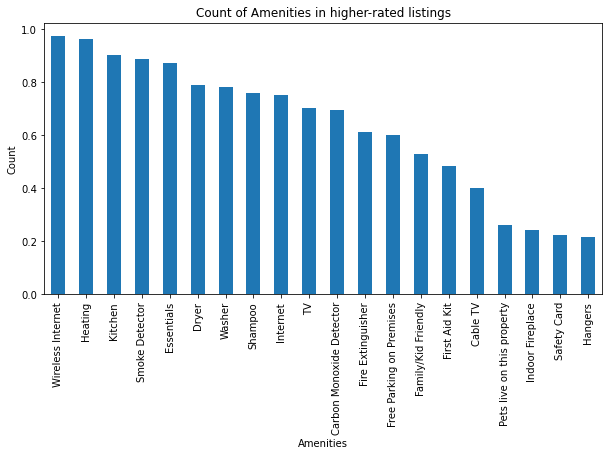

In [110]:
category_counts = q2_df.iloc[:,1:].mean().sort_values(ascending=False)[:20]

# Plot the counts as a bar plot
plt.figure(figsize=(10,5))
category_counts.plot(kind='bar')
plt.xlabel('Amenities')
plt.ylabel('Count')
plt.title('Count of Amenities in higher-rated listings')
plt.show()

### Conclusion
As we can see from the graph above, we can see the top 20 amenities assocaited with higher-rated listings (starting at 95). And we can also see that some amenities are almost always associated with those listings.

## Question 3
#### Are there any trends or patterns in the types of guests who tend to book Seattle Airbnb listings (e.g. age, gender, nationality), and how might this data be useful for hosts?